In [1]:
import numpy as np
import gstools as gs
import matplotlib.pyplot as plt
from math import *
from tqdm import tqdm
import pandas as pd
from scipy import interpolate


In [2]:
vals = 1+np.arange(1,2)
Nr = 10 # n repeats

  0%|          | 0/10 [00:00<?, ?it/s]

0.2


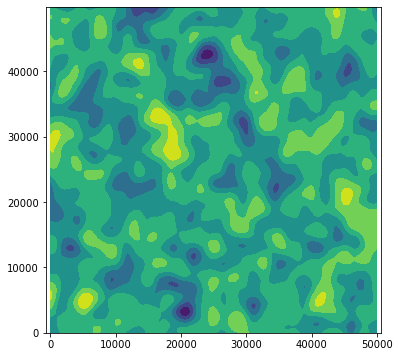

 10%|█         | 1/10 [01:53<17:01, 113.46s/it]

0.2


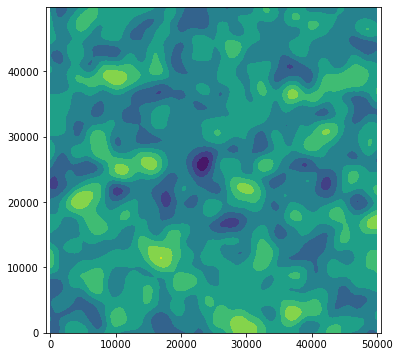

 20%|██        | 2/10 [03:46<15:07, 113.45s/it]

0.2


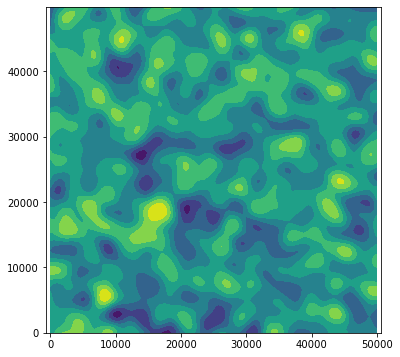

 30%|███       | 3/10 [05:49<13:42, 117.52s/it]

0.2


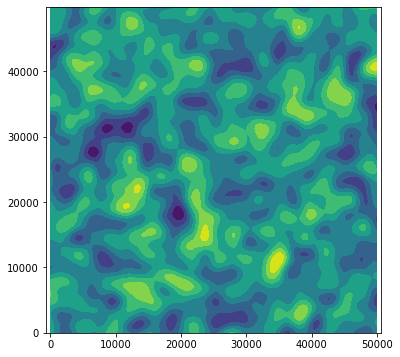

 40%|████      | 4/10 [07:47<11:46, 117.83s/it]

0.2


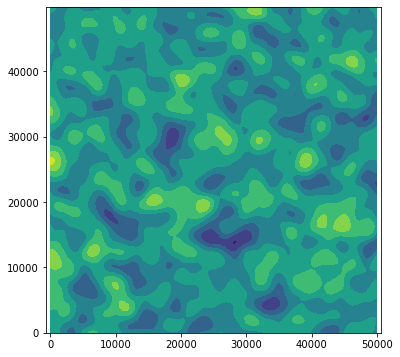

 50%|█████     | 5/10 [09:41<09:41, 116.29s/it]

0.2


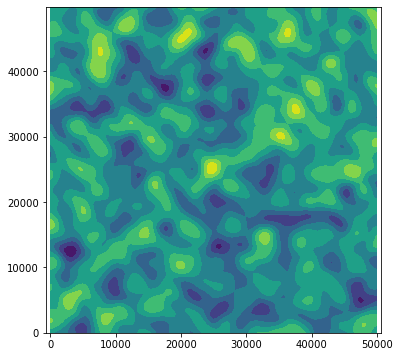

 60%|██████    | 6/10 [11:31<07:36, 114.21s/it]

0.2


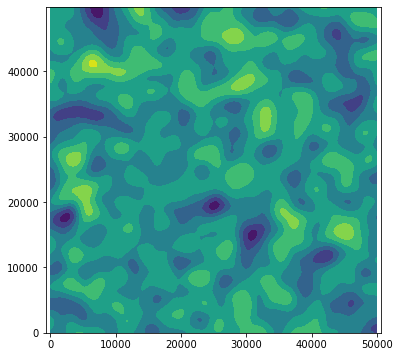

 70%|███████   | 7/10 [13:26<05:43, 114.52s/it]

0.2


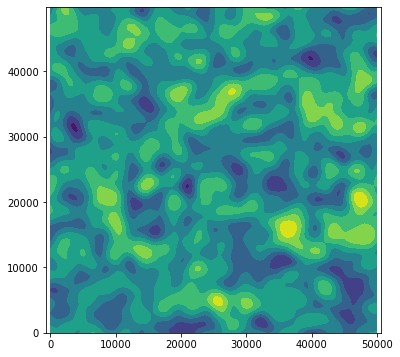

 80%|████████  | 8/10 [15:23<03:50, 115.48s/it]

0.2


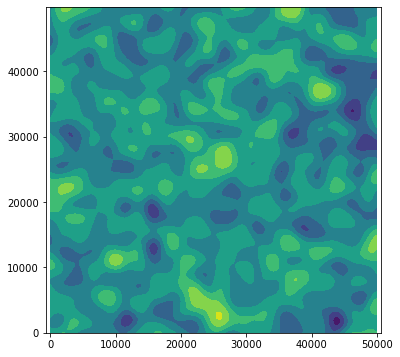

 90%|█████████ | 9/10 [17:23<01:56, 116.64s/it]

0.2


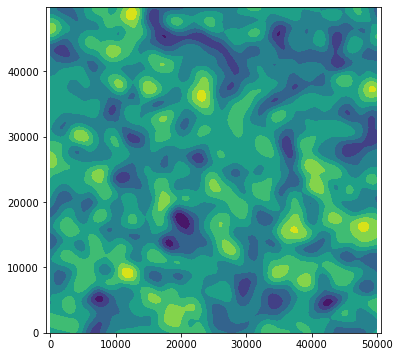

100%|██████████| 10/10 [19:18<00:00, 115.83s/it]


In [3]:
for r in tqdm(range(Nr)):

    for v in vals:
        p = 0.1*v
        print(p)
        
        # make a random field with 2k correlation length
        x = y = np.arange(0,50000,100)
        L = 2000
        var=0.5

        model = gs.Exponential(dim=2, var=var, len_scale=L)
        srf = gs.SRF(model)
        field = srf.structured([x, y])

        
        # make a random field with 2k correlation length
        x = y = np.arange(0,50000,100)
        L = 2000
        var=0.5

        model = gs.Gaussian(dim=2, var=var, len_scale=L)
        srf = gs.SRF(model)
        cvfield = srf.structured([x, y])
        plt.figure(figsize=(6,6))
        plt.contourf(x,y,cvfield)
        plt.axis('equal')
        plt.show()
        # make a 5k presence-absence field
        L = 4000
        var = 1
        #working model = gs.Matern(nu=1.5,dim=2, var=var, len_scale=L)
        model = gs.Gaussian(dim=2, var=var, len_scale=L)
        srf = gs.SRF(model)
        
        # we make the pa field bigger so we can centre it on the largest cluster of wildebeest
        x2 = y2 = np.arange(-50000,100000,1000)
        pa_field = srf.structured([x2, y2])
        # interpolate as the grid generation is slow for large N
        f = interpolate.interp2d(x2, y2, pa_field, kind='cubic')
        x2 = y2 = np.arange(-50000,100000,100)

        pa_field = f(x2,y2)

#         plt.figure(figsize=(6,6))
#         plt.contourf(x2,y2,pa_field)
#         plt.axis('equal')
#         plt.show()
        # next we find the highest value of the pa field
        ij = pa_field[500:1000,500:1000].argmax()
        # and centre it so it's at the middle of the survey
        i = ij//500
        j = ij - i*500
        pa_field2 = pa_field[500+i-250:500+i+250,500+j-250:500+j+250]
#         plt.figure(figsize=(6,6))
#         plt.contourf(x,y,pa_field2)
#         plt.axis('equal')
#         plt.show()
        # only populate the top p%
        cutoff = np.percentile(pa_field2,100*(1-p))

        # set to negative infinity sets it to zero when we take the exponential
        field[pa_field2<cutoff]=-np.inf
        cvfield[pa_field2<cutoff]=-np.inf

#         plt.figure(figsize=(6,6))
#         plt.contourf(x,y,field)
#         plt.axis('equal')
#         plt.show()

        #set the mean so we end up with roughly 1.3m wildebeest
        target_w = 1300000
        vf = np.var(field[np.isfinite(field)]+cvfield[np.isfinite(field)])
        mf = np.mean(field[np.isfinite(field)]+cvfield[np.isfinite(field)])
        target_log_density = np.log(target_w/(p*50000*50000))-0.5*vf-mf
        
        # generate a random count for each grid cell of 100mx100m
        wcounts = np.random.poisson(lam = 100*100*np.exp(target_log_density+field+cvfield))

        outputfile = '../data/simdata/cv_field_p' + str(v) + '_r' + str(r) + '.npy'
    
        np.save(outputfile,cvfield)
        # next place the wildebeest in a random location within their cell
        total = wcounts.sum()
        positions = np.zeros((total,2))

        min_x = 0
        max_x = 50000
        min_y = 0
        max_y = 50000
        #print(total)
        w = 0
        for i in (range(len(x))):
            for j in range(len(y)):
                wtotal =  wcounts[i,j]
                positions[w:w+wtotal,0]=x[i]+np.random.uniform(100,size=wtotal) # place at random in the 100x100 cell
                positions[w:w+wtotal,1]=y[j]+np.random.uniform(100,size=wtotal)
                w = w + wtotal

#         plt.figure(figsize=(6,6))
#         plt.hist2d(positions[:,0],positions[:,1], vmax=1,bins=500,cmap='Greys')
#         #plt.scatter(positions[:,0],positions[:,1],s=0.01,c='k')

#         plt.axis('equal')
#         plt.show()

        # fly the survey
        yvals = np.arange(positions[:,1].min(),positions[:,1].max(),2500)
        yvals = np.arange(135,max_y,2500)
        photos=[]
        transect=0
        for yv in (yvals):

            ymin = yv - 135
            ymax = yv + 135
            #if np.any((positions[:,1]>=ymin)&(positions[:,1]<=ymax)):

                #xvals = np.arange(positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].min(),positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].max(),500)
            xvals = np.arange(90,max_x,500)

                #xvals = np.arange(positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].min(),positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].max(),250)
            #else:
            #    continue
            if len(xvals):
                transect+=1

            for xv in xvals:

                xrand = 0#np.random.uniform(-10,10)
                # images are 180x270 metres
                xmin = xv - 90
                xmax = xv + 90
                xmin = xmin + xrand
                xmax = xmax + xrand

                yrand = 0#np.random.uniform(-10,10)
                ymin = ymin + yrand
                ymax = ymax + yrand

                count = np.sum((positions[:,0]>xmin)&(positions[:,0]<xmax)&(positions[:,1]>ymin)&(positions[:,1]<ymax))
                #if count>0:

                photo = [xv+xrand,yv+yrand,count,transect]
                photos.append(photo)

        photos = np.array(photos)    
#         plt.figure(figsize=(6,6))
#         plt.scatter(photos[:,0],photos[:,1],s=photos[:,2])

#         plt.scatter(photos[:,0],photos[:,1],s=0.1)

#         plt.axis('equal')
#         plt.show()

        # save the data
        outputfile = 'simdata/cv_simdata_p' + str(v) + '_r' + str(r) + '.csv'
        f = open(outputfile,'w')
        f.write("x,y,wildebeest,transect_id,photo_area\n")

        x_str = '%.2f,' % 0
        y_str = '%.2f,' % 0
        w_str = '%d,' % total
        t_str = '%d,' % -1
        a_str = '%d' % 0
        f.write(x_str + y_str + w_str + t_str + a_str )
        f.write('\n')
        for photo in photos:
            x_str = '%.2f,' % (photo[0]/1)
            y_str = '%.2f,' % (photo[1]/1)
            w_str = '%d,' % photo[2]
            t_str = '%d,' % photo[3]
            a_str = '%.6f' % (180*270/1/1)
            f.write(x_str + y_str + w_str + t_str + a_str )
            f.write('\n')
        f.close()
        #break
    #break

In [206]:
ls data

simdata_p10_r0.csv  simdata_p2_r5.csv  simdata_p5_r0.csv  simdata_p7_r5.csv
simdata_p10_r1.csv  simdata_p2_r6.csv  simdata_p5_r1.csv  simdata_p7_r6.csv
simdata_p10_r2.csv  simdata_p2_r7.csv  simdata_p5_r2.csv  simdata_p7_r7.csv
simdata_p10_r3.csv  simdata_p2_r8.csv  simdata_p5_r3.csv  simdata_p7_r8.csv
simdata_p10_r4.csv  simdata_p2_r9.csv  simdata_p5_r4.csv  simdata_p7_r9.csv
simdata_p10_r5.csv  simdata_p3_r0.csv  simdata_p5_r5.csv  simdata_p8_r0.csv
simdata_p10_r6.csv  simdata_p3_r1.csv  simdata_p5_r6.csv  simdata_p8_r1.csv
simdata_p10_r7.csv  simdata_p3_r2.csv  simdata_p5_r7.csv  simdata_p8_r2.csv
simdata_p10_r8.csv  simdata_p3_r3.csv  simdata_p5_r8.csv  simdata_p8_r3.csv
simdata_p10_r9.csv  simdata_p3_r4.csv  simdata_p5_r9.csv  simdata_p8_r4.csv
simdata_p1_r0.csv   simdata_p3_r5.csv  simdata_p6_r0.csv  simdata_p8_r5.csv
simdata_p1_r1.csv   simdata_p3_r6.csv  simdata_p6_r1.csv  simdata_p8_r6.csv
simdata_p1_r2.csv   simdata_p3_r7.csv  simdata_p6_r2.csv  simdata_p8_r7.csv
simdata_p1_r

In [28]:
outputfile

'simdata_p10.npy'

In [9]:
# convert to probability and specify area occupied
p = 0.1 # fraction occupied


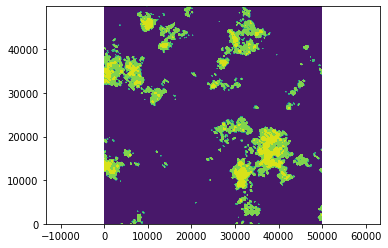

1349986


100%|██████████| 500/500 [00:02<00:00, 173.03it/s]


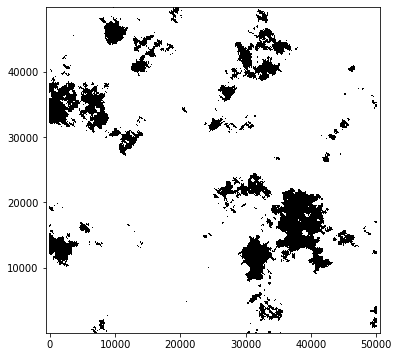

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


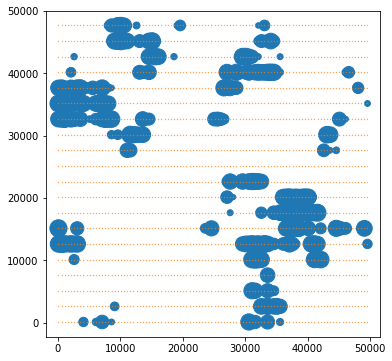

In [ ]:
import numpy as np
from scipy.stats import truncexpon
import matplotlib.pyplot as plt
import powerlaw
from math import *
from tqdm import tqdm
import pandas as pd
from scipy import interpolate

In [417]:
#conda install gstools

<AxesSubplot:title={'center':'Field 2D structured: (500, 500)'}, xlabel='$x$', ylabel='$y$'>

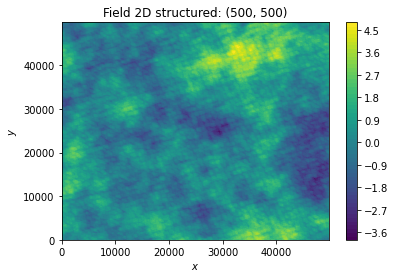

0.00054

In [420]:
a = np.log(200)

#plt.hist(sfield.ravel())
#plt.show()

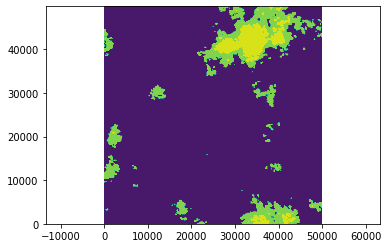

0.0005400000000000001

In [421]:

(sfield).mean()

In [422]:
f = interpolate.interp2d(x, y, sfield, kind='cubic')

In [423]:
xnew = ynew = np.arange(0,50000,100)

In [424]:
#fullfield = f(xnew,ynew)
wcounts = np.random.binomial(10000,sfield)
#aa.shape

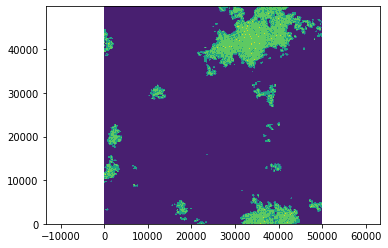

In [425]:
plt.contourf(xnew,ynew,wcounts.T)
plt.axis('equal')
plt.show()

1350587

100%|██████████| 500/500 [00:03<00:00, 155.69it/s]


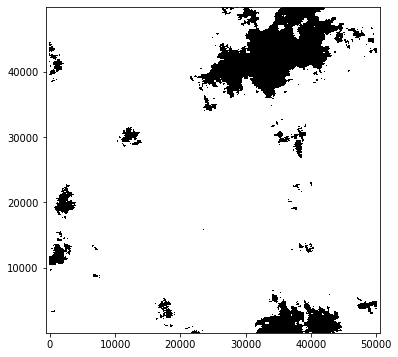

In [428]:
plt.figure(figsize=(6,6))
plt.hist2d(positions[:,0],positions[:,1], vmax=1,bins=500,cmap='Greys')
#plt.scatter(positions[:,0],positions[:,1],s=0.01,c='k')

plt.axis('equal')
plt.show()

100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


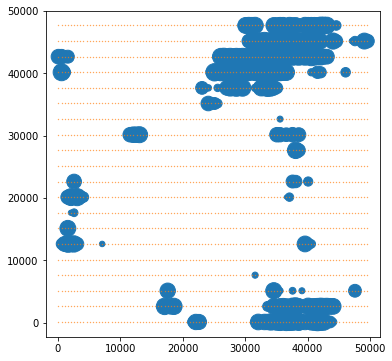

In [430]:
plt.figure(figsize=(6,6))
plt.scatter(photos[:,0],photos[:,1],s=photos[:,2])

plt.scatter(photos[:,0],photos[:,1],s=0.1)

plt.axis('equal')
plt.show()

In [431]:
outputfile = 'simdatanew.csv'#_clustered_data_uniform_sampling.csv'
f = open(outputfile,'w')
f.write("x,y,wildebeest,transect_id,photo_area\n")

x_str = '%.2f,' % 0
y_str = '%.2f,' % 0
w_str = '%d,' % total
t_str = '%d,' % -1
a_str = '%d' % 0
f.write(x_str + y_str + w_str + t_str + a_str )
f.write('\n')
for photo in photos:
    x_str = '%.2f,' % (photo[0]/1)
    y_str = '%.2f,' % (photo[1]/1)
    w_str = '%d,' % photo[2]
    t_str = '%d,' % photo[3]
    a_str = '%.6f' % (180*270/1/1)
    f.write(x_str + y_str + w_str + t_str + a_str )
    f.write('\n')
f.close()


In [432]:
positions[:,1]

array([10547.57495103, 10524.56072396, 10591.81992553, ...,
       46306.52176831, 46352.17147984, 46398.30369479])

In [433]:
photos[:,2].max()

327

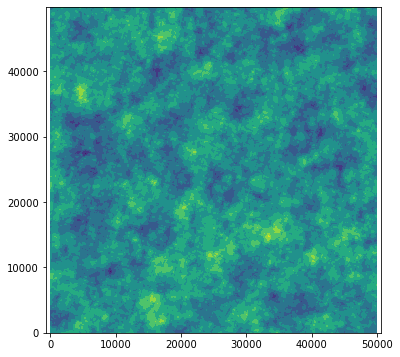

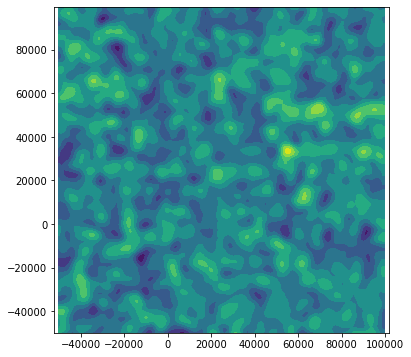

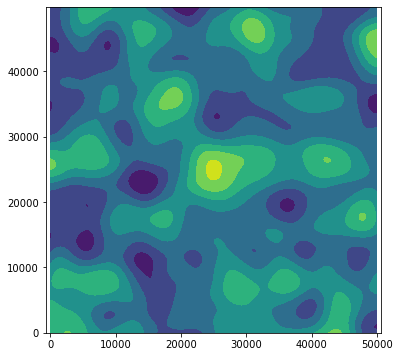

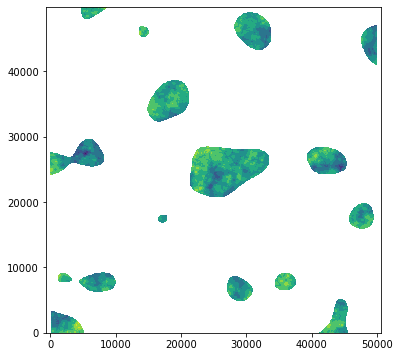

100%|██████████| 500/500 [00:04<00:00, 111.47it/s]


In [17]:
from scipy import interpolate

p = 0.1

# make a random field with 5k correlation length
x = y = np.arange(0,50000,100)
L = 2000
var = 1
model = gs.Exponential(nu=1.5,dim=2, var=var, len_scale=L)
srf = gs.SRF(model)

field = srf.structured([x, y])

plt.figure(figsize=(6,6))
plt.contourf(x,y,field)
plt.axis('equal')
plt.show()
L = 4000
var = 1
model = gs.Gaussian(nu=1.5,dim=2, var=var, len_scale=L)
srf = gs.SRF(model)

x2 = y2 = np.arange(-50000,100000,1000)

pa_field = srf.structured([x2, y2])



f = interpolate.interp2d(x2, y2, pa_field, kind='cubic')

x2 = y2 = np.arange(-50000,100000,100)

pa_field = f(x2,y2)

plt.figure(figsize=(6,6))
plt.contourf(x2,y2,pa_field)
plt.axis('equal')
plt.show()
ij = pa_field[500:1000,500:1000].argmax()

i = ij//500
j = ij - i*500
pa_field2 = pa_field[500+i-250:500+i+250,500+j-250:500+j+250]
plt.figure(figsize=(6,6))
plt.contourf(x,y,pa_field2)
plt.axis('equal')
plt.show()

cutoff = np.percentile(pa_field2,100*(1-p))

field[pa_field2<cutoff]=-np.inf

plt.figure(figsize=(6,6))
plt.contourf(x,y,field)
plt.axis('equal')
plt.show()

target_w = 1300000
vf = np.var(field[np.isfinite(field)])
mf = np.mean(field[np.isfinite(field)])
target_log_density = np.log(target_w/(p*50000*50000))-0.5*vf-mf
wcounts = np.random.poisson(lam = 100*100*np.exp(target_log_density+field))

total = wcounts.sum()
positions = np.zeros((total,2))

min_x = 0
max_x = 50000
min_y = 0
max_y = 50000
#print(total)
w = 0
for i in tqdm(range(len(x))):
    for j in range(len(y)):
        wtotal =  wcounts[i,j]
        positions[w:w+wtotal,0]=x[i]+np.random.uniform(100,size=wtotal) # place at random in the 100x100 cell
        positions[w:w+wtotal,1]=y[j]+np.random.uniform(100,size=wtotal)
        w = w + wtotal


In [18]:
pa_field2.shape

(500, 500)

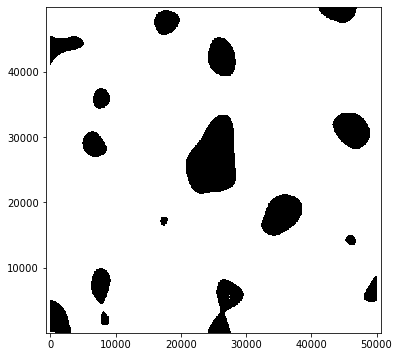

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


In [19]:
# target_w = 1300000
# vf = np.var(field[np.isfinite(field)])
# mf = np.mean(field[np.isfinite(field)])
# target_log_density = np.log(target_w/(p*50000*50000))-0.5*vf-mf
# wcounts = np.random.poisson(lam = 100*100*np.exp(target_log_density+field))

# total = wcounts.sum()
# positions = np.zeros((total,2))

# min_x = 0
# max_x = 50000
# min_y = 0
# max_y = 50000
# #print(total)
# w = 0
# for i in tqdm(range(len(x))):
#     for j in range(len(y)):
#         wtotal =  wcounts[i,j]
#         positions[w:w+wtotal,0]=x[i]+np.random.uniform(100,size=wtotal) # place at random in the 100x100 cell
#         positions[w:w+wtotal,1]=y[j]+np.random.uniform(100,size=wtotal)
#         w = w + wtotal

plt.figure(figsize=(6,6))
plt.hist2d(positions[:,0],positions[:,1], vmax=1,bins=500,cmap='Greys')
#plt.scatter(positions[:,0],positions[:,1],s=0.01,c='k')

plt.axis('equal')
plt.show()

# positions = np.zeros((0,2))
# for i in (range(len(x))):
#     for j in range(len(y)):
#         wtotal =  wcounts[i,j]
#         positions[w:w+wtotal,0]=x[i]+np.random.uniform(100,size=wtotal) # place at random in the 100x100 cell
#         positions[w:w+wtotal,1]=y[j]+np.random.uniform(100,size=wtotal)
#         w = w + wtotal
wcounts.sum()

yvals = np.arange(positions[:,1].min(),positions[:,1].max(),2500)
yvals = np.arange(135,max_y,2500)
photos=[]
transect=0
for yv in tqdm(yvals):

    ymin = yv - 135
    ymax = yv + 135
    #if np.any((positions[:,1]>=ymin)&(positions[:,1]<=ymax)):

        #xvals = np.arange(positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].min(),positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].max(),500)
    xvals = np.arange(90,max_x,500)

        #xvals = np.arange(positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].min(),positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].max(),250)
    #else:
    #    continue
    if len(xvals):
        transect+=1

    for xv in xvals:

        xrand = 0#np.random.uniform(-10,10)
        # images are 180x270 metres
        xmin = xv - 90
        xmax = xv + 90
        xmin = xmin + xrand
        xmax = xmax + xrand

        yrand = 0#np.random.uniform(-10,10)
        ymin = ymin + yrand
        ymax = ymax + yrand

        count = np.sum((positions[:,0]>xmin)&(positions[:,0]<xmax)&(positions[:,1]>ymin)&(positions[:,1]<ymax))
        #if count>0:

        photo = [xv+xrand,yv+yrand,count,transect]
        photos.append(photo)

photos = np.array(photos)    

In [20]:
(photos[:,2]==0).sum()

1777

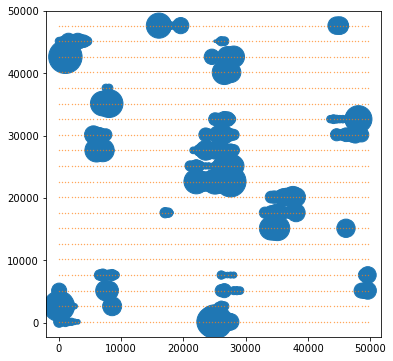

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(photos[:,0],photos[:,1],s=photos[:,2])

plt.scatter(photos[:,0],photos[:,1],s=0.1)

plt.axis('equal')
plt.show()

# save the data
outputfile = 'simdata_p223.csv'
f = open(outputfile,'w')
f.write("x,y,wildebeest,transect_id,photo_area\n")

x_str = '%.2f,' % 0
y_str = '%.2f,' % 0
w_str = '%d,' % total
t_str = '%d,' % -1
a_str = '%d' % 0
f.write(x_str + y_str + w_str + t_str + a_str )
f.write('\n')
for photo in photos:
    x_str = '%.2f,' % (photo[0]/1)
    y_str = '%.2f,' % (photo[1]/1)
    w_str = '%d,' % photo[2]
    t_str = '%d,' % photo[3]
    a_str = '%.6f' % (180*270/1/1)
    f.write(x_str + y_str + w_str + t_str + a_str )
    f.write('\n')
f.close()

In [22]:
np.exp(target_log_density+field)

array([[0.        , 0.        , 0.01102883, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00953944, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00847021, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
np.isinf(field).sum()/(np.isinf(field).sum()+np.isfinite(field).sum())
np.var(field[np.isfinite(field)])
np.mean(field[np.isfinite(field)])

-0.24034992989161572

In [95]:
target_log_density = np.log(target_w/(50000*50000))-0.5*np.var(field[np.isfinite(field)])-0.128

wcounts = np.random.poisson(lam = 100*100*np.exp(target_log_density),size=field.shape)
wcounts = np.random.poisson(lam = 100*100*np.exp(target_log_density+field))

wcounts.sum()

aa = 100*100*np.exp(target_log_density+field)
aa.mean()*500*500

134624.38154531326

In [101]:
field3=field[np.isfinite(field)]
field3=field3-field3.mean()

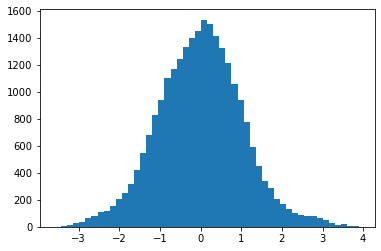

In [102]:
plt.hist(field3,bins=50)
plt.show()

In [ ]:
        sfield = 1/(1+np.exp(-field))
        
        sfield[sfield<cutoff]=0

        # calculate average field value to get approx. 1.35m wildebeest
        target_w = 1350000
        ncells = 50000*50000

        frac = target_w/ncells

        sfield = frac*sfield/sfield.mean()

#         plt.contourf(x,y,sfield.T)
#         plt.axis('equal')
#         plt.show()

        wcounts = np.random.binomial(10000,sfield) # each 100x100 metre cell can have up to 1 wildebeest per m2

        total = wcounts.sum()
        positions = np.zeros((total,2))

        min_x = 0
        max_x = 50000
        min_y = 0
        max_y = 50000
        #print(total)
        w = 0
        for i in (range(len(x))):
            for j in range(len(y)):
                wtotal =  wcounts[i,j]
                positions[w:w+wtotal,0]=x[i]+np.random.uniform(100,size=wtotal) # place at random in the 100x100 cell
                positions[w:w+wtotal,1]=y[j]+np.random.uniform(100,size=wtotal)
                w = w + wtotal

#         plt.figure(figsize=(6,6))
#         plt.hist2d(positions[:,0],positions[:,1], vmax=1,bins=500,cmap='Greys')
#         #plt.scatter(positions[:,0],positions[:,1],s=0.01,c='k')

#         plt.axis('equal')
#         plt.show()

        # fly the survey

        yvals = np.arange(positions[:,1].min(),positions[:,1].max(),2500)
        yvals = np.arange(135,max_y,2500)
        photos=[]
        transect=0
        for yv in (yvals):

            ymin = yv - 135
            ymax = yv + 135
            #if np.any((positions[:,1]>=ymin)&(positions[:,1]<=ymax)):

                #xvals = np.arange(positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].min(),positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].max(),500)
            xvals = np.arange(90,max_x,500)

                #xvals = np.arange(positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].min(),positions[(positions[:,1]>=ymin)&(positions[:,1]<=ymax),0].max(),250)
            #else:
            #    continue
            if len(xvals):
                transect+=1

            for xv in xvals:

                xrand = 0#np.random.uniform(-10,10)
                # images are 180x270 metres
                xmin = xv - 90
                xmax = xv + 90
                xmin = xmin + xrand
                xmax = xmax + xrand

                yrand = 0#np.random.uniform(-10,10)
                ymin = ymin + yrand
                ymax = ymax + yrand

                count = np.sum((positions[:,0]>xmin)&(positions[:,0]<xmax)&(positions[:,1]>ymin)&(positions[:,1]<ymax))
                #if count>0:

                photo = [xv+xrand,yv+yrand,count,transect]
                photos.append(photo)

        photos = np.array(photos)    
#         plt.figure(figsize=(6,6))
#         plt.scatter(photos[:,0],photos[:,1],s=photos[:,2])

#         plt.scatter(photos[:,0],photos[:,1],s=0.1)

#         plt.axis('equal')
#         plt.show()

        # save the data
        outputfile = 'simdata_p' + str(v) + '_r' + str(r) + '.csv'
        f = open(outputfile,'w')
        f.write("x,y,wildebeest,transect_id,photo_area\n")

        x_str = '%.2f,' % 0
        y_str = '%.2f,' % 0
        w_str = '%d,' % total
        t_str = '%d,' % -1
        a_str = '%d' % 0
        f.write(x_str + y_str + w_str + t_str + a_str )
        f.write('\n')
        for photo in photos:
            x_str = '%.2f,' % (photo[0]/1)
            y_str = '%.2f,' % (photo[1]/1)
            w_str = '%d,' % photo[2]
            t_str = '%d,' % photo[3]
            a_str = '%.6f' % (180*270/1/1)
            f.write(x_str + y_str + w_str + t_str + a_str )
            f.write('\n')
        f.close()
